# Анализ продаж интернет-магазина

### Описание

Датасет содержит информацию о продажах товаров в интернет-магазине в 2019 г.

Описание столбцов:

1. Order ID: ID заказа.
2. Product: название товара.
3. Quantity Ordered: количество товаров в заказе.
4. Price Each: цена за единицу.
5. Order Date: дата заказа.
6. Purchase Address: адрес доставки.

Источник: https://www.kaggle.com/knightbearr/sales-product-data

### Загрузка данных и очистка датасета

Создадим один датасет из имеющихся файлов и отсортируем данные по дате.

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import glob
from itertools import combinations


file_directory = glob.glob('./archive/*.csv')
df = pd.read_csv(file_directory[0])
for file in glob.glob('./archive/*.csv')[1:]:
    df = pd.concat([df, pd.read_csv(file)])
df.sort_values(by='Order Date', inplace=True, ignore_index=True)
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,147268,Wired Headphones,1,11.99,01/01/19 03:07,"9 Lake St, New York City, NY 10001"
1,148041,USB-C Charging Cable,1,11.95,01/01/19 03:40,"760 Church St, San Francisco, CA 94016"
2,149343,Apple Airpods Headphones,1,150,01/01/19 04:56,"735 5th St, New York City, NY 10001"
3,149964,AAA Batteries (4-pack),1,2.99,01/01/19 05:53,"75 Jackson St, Dallas, TX 75001"
4,149350,USB-C Charging Cable,2,11.95,01/01/19 06:03,"943 2nd St, Atlanta, GA 30301"


Удалим дублирующиеся заголовки из датасета:

In [120]:
df = df[df['Order ID'] != 'Order ID']

Посмотрим на структуру данных, выясним, есть ли пропущенные значения.

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186495 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          185950 non-null  object
 1   Product           185950 non-null  object
 2   Quantity Ordered  185950 non-null  object
 3   Price Each        185950 non-null  object
 4   Order Date        185950 non-null  object
 5   Purchase Address  185950 non-null  object
dtypes: object(6)
memory usage: 5.7+ MB


In [122]:
df.isnull().sum()

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64

В датасете 545 пустых строк, удалим их.

In [123]:
df.dropna(inplace=True)

Для дальнейшего анализа необходимо перевести перевести столбцы Quantity Ordered и Price Each в числовой формат (int и float соответственно), а столбец Order Date - в формат даты.

In [124]:
df['Quantity Ordered'] = df['Quantity Ordered'].astype('int')
df['Price Each'] = df['Price Each'].astype('float')
df['Order Date'] = pd.to_datetime(df['Order Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185950 entries, 0 to 185949
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  object        
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int32         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(3)
memory usage: 7.1+ MB


### Задания

#### 1. В каком месяце объем продаж был максимальным? Чему он был равен?

In [125]:
# настройки отображения чисел
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# настройки отображения графиков
plt.rc('axes', axisbelow=True)

# извлечем название месяца из даты
df['month'] = df['Order Date'].dt.month_name()
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
df['month'] = pd.Categorical(df['month'], categories=months, ordered=True)

# рассчитаем выручку
df['revenue'] = df['Quantity Ordered'] * df['Price Each']

# произведем группировку и построим таблицу
sales_by_month = df.groupby('month', as_index=False).agg({'revenue': 'sum'}) \
                   .sort_values(by='revenue', ascending=False)
sales_by_month.reset_index(drop=True, inplace=True)
sales_by_month.index += 1
sales_by_month

,month,revenue
1,December,4613443.34
2,October,3736726.88
3,April,3390670.24
4,November,3199603.20
5,May,3152606.75
6,March,2807100.38
7,July,2647775.76
8,June,2577802.26
9,August,2244467.88
10,February,2202022.42


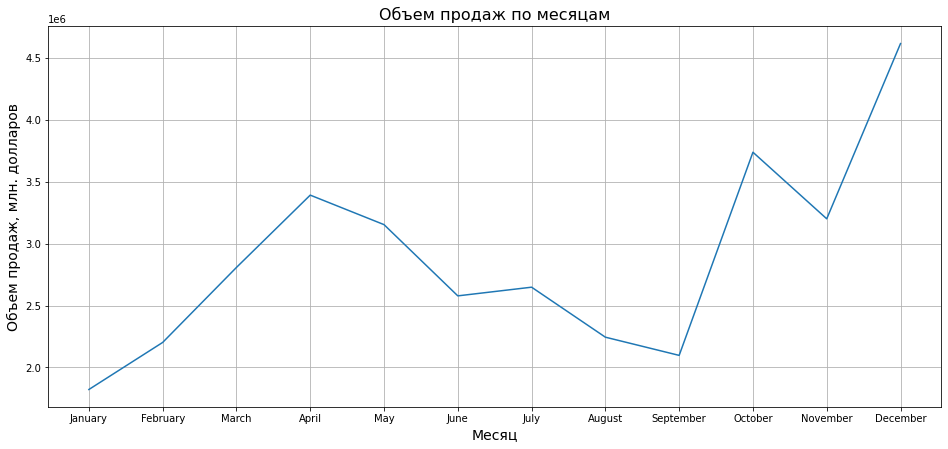

In [126]:
# упорядочим данные по месяцам и построим график
figure = plt.figure(figsize=(16, 7))
sns.lineplot(x='month', y='revenue', data=sales_by_month)
plt.title('Объем продаж по месяцам', fontdict={'fontsize': 16})
plt.xlabel('Месяц', fontdict={'fontsize': 14})
plt.ylabel('Объем продаж, млн. долларов', fontdict={'fontsize': 14})
plt.grid()
plt.show()

Максимальный объем продаж был зафиксирован в декабре, его размер составил 4 613 443.34 долл. Рост продаж в конце года можно объяснить покупкой подарков к праздникам.

#### 2. В каком городе и каком штате объем продаж был максимальным?

In [127]:
# извлечем название города из столбца Purchase Address

df['city'] = df['Purchase Address'].str.split(', ').apply(lambda x: x[1])
df['state'] = df['Purchase Address'].str.split(', ').apply(lambda x: x[2][:2])
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,month,revenue,city,state
0,147268,Wired Headphones,1,11.99,2019-01-01 03:07:00,"9 Lake St, New York City, NY 10001",January,11.99,New York City,NY
1,148041,USB-C Charging Cable,1,11.95,2019-01-01 03:40:00,"760 Church St, San Francisco, CA 94016",January,11.95,San Francisco,CA
2,149343,Apple Airpods Headphones,1,150.00,2019-01-01 04:56:00,"735 5th St, New York City, NY 10001",January,150.00,New York City,NY
3,149964,AAA Batteries (4-pack),1,2.99,2019-01-01 05:53:00,"75 Jackson St, Dallas, TX 75001",January,2.99,Dallas,TX
4,149350,USB-C Charging Cable,2,11.95,2019-01-01 06:03:00,"943 2nd St, Atlanta, GA 30301",January,23.90,Atlanta,GA


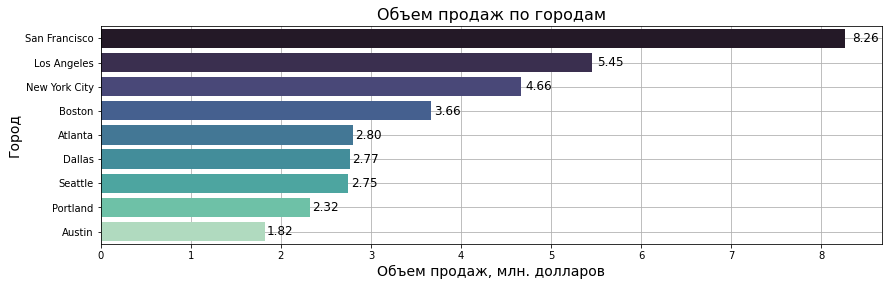

In [128]:
# произведем группировку по городу
sales_by_city = df.groupby('city', as_index=False).agg({'revenue': 'sum'}) \
                  .sort_values(by='revenue', ascending=False)

# визуализация
figure = plt.figure(figsize=(14, 4))
bars = sns.barplot(x='revenue', y='city', data=sales_by_city, palette='mako')
for p in bars.patches:
    annot = '{:.2f}'.format(p.get_width() / 1000000)
    x = p.get_width() * 1.01
    y = p.get_y() + p.get_height() - 0.25
    bars.annotate(annot, (x, y), size = 12)
plt.grid()
plt.title("Объем продаж по городам", fontdict={'fontsize': 16})
plt.xlabel("Объем продаж, млн. долларов", fontdict={'fontsize': 14})
plt.ylabel("Город", fontdict={'fontsize': 14})
xlabels = ['{:,.0f}'.format(x) for x in bars.get_xticks()/1000000]
bars.set_xticklabels(xlabels)
plt.show()

In [129]:
sales_by_city.reset_index(drop=True, inplace=True)
sales_by_city.index += 1
sales_by_city

,city,revenue
1,San Francisco,8262203.91
2,Los Angeles,5452570.80
3,New York City,4664317.43
4,Boston,3661642.01
5,Atlanta,2795498.58
6,Dallas,2767975.40
7,Seattle,2747755.48
8,Portland,2320490.61
9,Austin,1819581.75


Максимальный объем продаж в разрезе городов (8 262 203.91 долл.) был в Сан-Франциско.

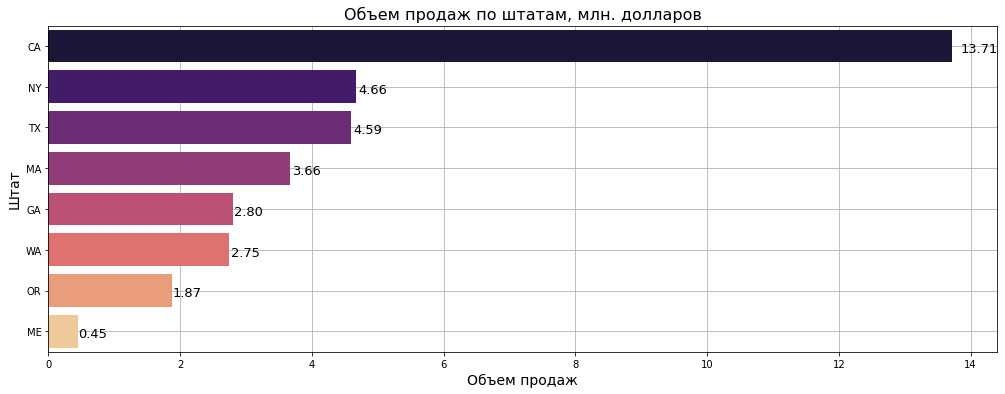

In [130]:
# произведем группировку по штату
sales_by_state = df.groupby('state', as_index=False).agg({'revenue': 'sum'}) \
                  .sort_values(by='revenue', ascending=False)
# визуализация
figure = plt.figure(figsize=(17, 6))
plt.ticklabel_format(style = 'plain')
bars = sns.barplot(x='revenue', y='state', data=sales_by_state, palette='magma')
for p in bars.patches:
    annot = '{:.2f}'.format(p.get_width() / 1000000)
    x = p.get_width() * 1.01
    y = p.get_y() + p.get_height() - 0.25
    bars.annotate(annot, (x, y), size = 13)
plt.grid()
plt.title("Объем продаж по штатам, млн. долларов", fontdict={'fontsize': 16})
plt.xlabel("Объем продаж", fontdict={'fontsize': 14})
plt.ylabel("Штат", fontdict={'fontsize': 14})
xlabels = ['{:,.0f}'.format(x) for x in bars.get_xticks()/1000000]
bars.set_xticklabels(xlabels)
plt.show()

In [131]:
sales_by_state.reset_index(drop=True, inplace=True)
sales_by_state.index += 1
sales_by_state

,state,revenue
1,CA,13714774.71
2,NY,4664317.43
3,TX,4587557.15
4,MA,3661642.01
5,GA,2795498.58
6,WA,2747755.48
7,OR,1870732.34
8,ME,449758.27


Максимальный объем продаж в разрезе штатов (13 714 774.71 долл.) был в Калифорнии.

#### 3. В какое время лучше всего показывать пользователям рекламу, чтобы максимизировать вероятность совершения покупки? 

Чтобы ответить на этот вопрос, необходимо выяснить, в какое время пользователи совершают заказы, то есть когда они наиболее активны. Кроме того, необходимо определить, есль ли помимо внутридневных изменений спроса колебания по дням недели.

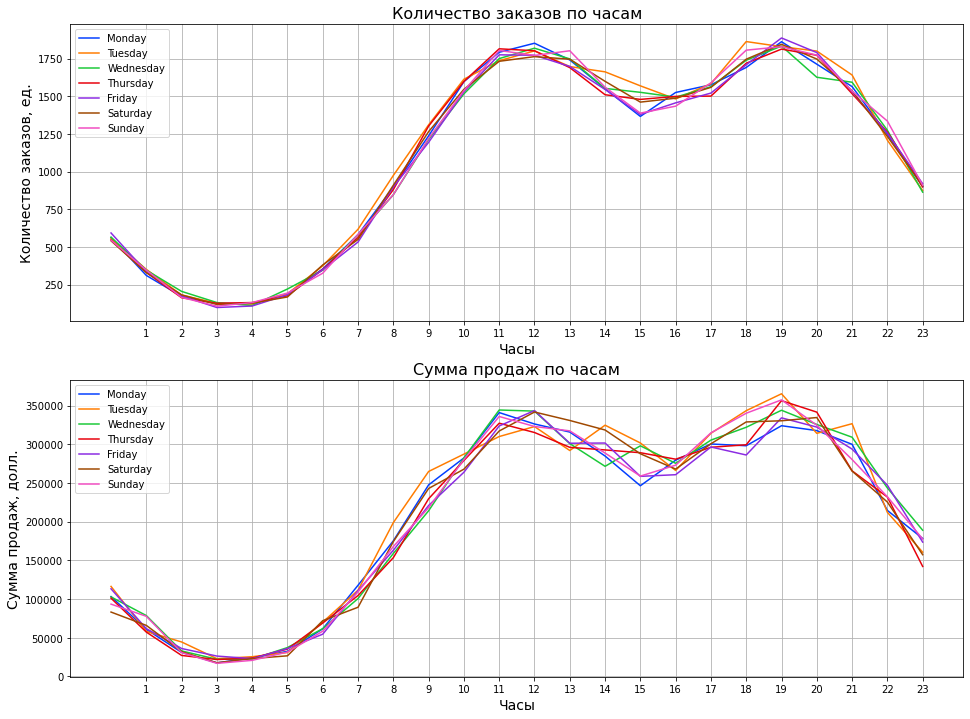

In [132]:
# извлечем часы из столбца с датой, а также день недели

df['hour'] = df['Order Date'].dt.hour
df['weekday'] = df['Order Date'].dt.weekday
sales_by_hours = df.groupby(['hour', 'weekday'], as_index=False).agg({'Order ID': 'count', 'revenue': 'sum'}) \
                    .rename(columns={'Order ID': 'number_of_orders'}) 

figure, axes = plt.subplots(2, 1, figsize=(16, 12))
sns.lineplot(x='hour', y='number_of_orders', data=sales_by_hours, hue='weekday', 
             ax=axes[0], palette='bright')
axes[0].set_xlabel('Часы', fontdict={'fontsize': 14})
axes[0].set_ylabel('Количество заказов, ед.', fontdict={'fontsize': 14})
axes[0].set_title('Количество заказов по часам', fontdict={'fontsize': 16})
axes[0].set_xticks(np.arange(1, 24))
axes[0].legend(labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[0].grid()

sns.lineplot(x='hour', y='revenue', data=sales_by_hours, hue='weekday', 
             ax=axes[1], palette='bright')
axes[1].set_xlabel('Часы', fontdict={'fontsize': 14})
axes[1].set_ylabel('Сумма продаж, долл.', fontdict={'fontsize': 14})
axes[1].set_title('Сумма продаж по часам', fontdict={'fontsize': 16})
axes[1].set_xticks(np.arange(1, 24))
axes[1].legend(labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[1].grid()

На графиках мы видим, что пользователи чаще всего совершают покупки с 11 до 12 часов, а также с 18 до 20 часов. День недели существенного влияния на спрос не оказывает. Имеет смысл показывать рекламу в начале роста активности пользователей: с 10 до 11 часов, а также с 17 до 18 часов.

#### 4. Какие товары чаще всего продаются вместе?

In [133]:
def combination_search(combination, orders):
    return len(orders[combination[0]] & orders[combination[1]])

orders = {}
for product in df['Product'].unique():
    orders[product] = set(df[df.Product == product]['Order ID'].tolist())
    
all_combinations = list(combinations(orders, 2))
count_combinations = [] 

for combination in all_combinations:
    count_combinations.append(combination_search(combination, orders))
paired_products = pd.DataFrame({'products': all_combinations, 'number': count_combinations}) \
                    .sort_values(by='number', ascending=False) \
                    .head(10).reset_index()
paired_products.drop('index', axis=1, inplace=True)
paired_products.index += 1
paired_products

,products,number
1,"(iPhone, Lightning Charging Cable)",1011
2,"(USB-C Charging Cable, Google Phone)",997
3,"(Wired Headphones, iPhone)",462
4,"(Wired Headphones, Google Phone)",422
5,"(Apple Airpods Headphones, iPhone)",373
6,"(USB-C Charging Cable, Vareebadd Phone)",368
7,"(Google Phone, Bose SoundSport Headphones)",228
8,"(Wired Headphones, USB-C Charging Cable)",203
9,"(Wired Headphones, Vareebadd Phone)",149
10,"(Wired Headphones, Lightning Charging Cable)",129


Чаще всего вместе продавались iPhone и Lightning Charging Cable, а также Google Phone и USB-C Charging Cable.

#### 5. Какой товар самый продаваемый? В чем причины высокого спроса на него?

Найдем топ-10 самых подаваемых товаров:

In [134]:
top_10 = df.groupby('Product').agg({'Quantity Ordered': 'sum'}) \
                              .sort_values(by='Quantity Ordered', ascending=False) \
                              .head(10).reset_index()
top_10.index += 1
top_10

,Product,Quantity Ordered
1,AAA Batteries (4-pack),31017
2,AA Batteries (4-pack),27635
3,USB-C Charging Cable,23975
4,Lightning Charging Cable,23217
5,Wired Headphones,20557
6,Apple Airpods Headphones,15661
7,Bose SoundSport Headphones,13457
8,27in FHD Monitor,7550
9,iPhone,6849
10,27in 4K Gaming Monitor,6244


Самый популярный товар - батарейки. За 2019 год было продано 31 017 упаковок батареек ААА и 27 635 упаковок батареек АА. Спрос на батарейки объясняется их невысокой ценой, а также тем, что батарейки являются расходным товаром с относительно коротким сроком службы.

#### 6. Как менялась динамика среднего чека по месяцам? В каком месяце средний чек был максимальным?

Посчитаем сумму по каждому заказу, а затем сгруппируем данные по месяцам и найдем среднее значение размера покупки.

In [135]:
orders_sum = df.groupby('month', as_index=False).agg({'revenue': 'sum', 'Order ID': 'count'}) \
                                                .rename(columns={'Order ID': 'orders'})
orders_sum['avg_order'] = orders_sum['revenue'] / orders_sum['orders']
orders_sum

,month,revenue,orders,avg_order
0,January,1822256.73,9709,187.69
1,February,2202022.42,11975,183.88
2,March,2807100.38,15153,185.25
3,April,3390670.24,18279,185.50
4,May,3152606.75,16566,190.31
5,June,2577802.26,13554,190.19
6,July,2647775.76,14293,185.25
7,August,2244467.88,11961,187.65
8,September,2097560.13,11621,180.50
9,October,3736726.88,20282,184.24


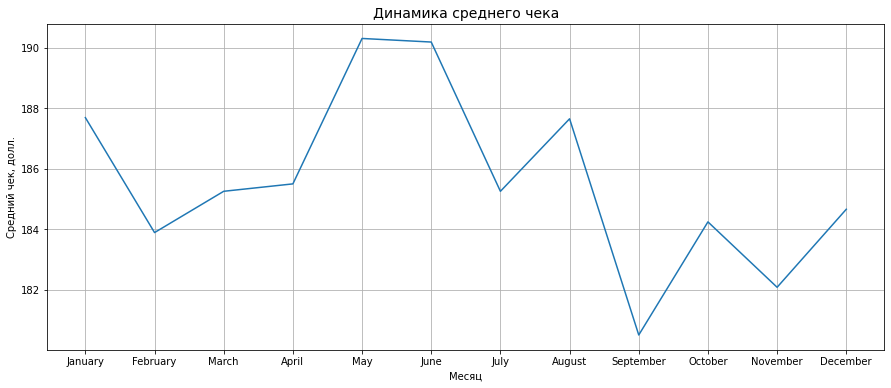

In [136]:
figure = plt.figure(figsize=(15, 6))
sns.lineplot(x='month', y='avg_order', data=orders_sum)
plt.grid()
plt.title("Динамика среднего чека", fontdict={'fontsize': 14})
plt.xlabel("Месяц")
plt.ylabel("Средний чек, долл.")
plt.show()

Средний чек был максимальным в мае, его значение равнялось 190.31 долл.

#### 7. Какова вероятность того, что в заказе будет USB-C Charging Cable?

Чтобы найти вероятность заказа конкретного товара, разделим количество заказов, в которых был данный товар, на общее количество заказов.

In [137]:
usb_c_orders = df[df.Product == 'USB-C Charging Cable']['Order ID'].nunique()
total = df['Order ID'].nunique()
print(f'Вероятность заказа USB-C Charging Cable равна {round(usb_c_orders / total, 3)}')

Вероятность заказа USB-C Charging Cable равна 0.122


#### 8.  Какова вероятность того, что в заказе будет iPhone?

In [138]:
iphone_orders = df[df.Product == 'iPhone']['Order ID'].nunique()
print(f'Вероятность заказа iPhone равна {round(iphone_orders / total, 3)}')

Вероятность заказа iPhone равна 0.038


#### 9.  Какова вероятность того, что в заказе будет Google Phone?

In [139]:
google_phone_orders = df[df.Product == 'Google Phone']['Order ID'].nunique()
print(f'Вероятность заказа Google Phone равна {round(google_phone_orders / total, 3)}')

Вероятность заказа Google Phone равна 0.031


#### 10.  Какова вероятность того, что в заказе будет Wired Headphones?

In [140]:
headphones_orders = df[df.Product == 'Wired Headphones']['Order ID'].nunique()
print(f'Вероятность заказа Wired Headphones равна {round(headphones_orders / total, 3)}')

Вероятность заказа Wired Headphones равна 0.106


#### 11. Какова вероятность того, что в заказе будут AAA Batteries (4-pack) и Wired Headphones вместе?

Вероятность того, что в заказе будет Wired Headphones, рассчитана в предыдущем задании. Аналогичным образом рассчитаем вероятность для AAA Batteries (4-pack), а затем умножим вероятности, чтобы найти ответ.

In [141]:
aaa_batteries_orders = df[df.Product == 'AAA Batteries (4-pack)']['Order ID'].nunique()
print('Вероятность того, что в заказе будут AAA Batteries (4-pack) и Wired Headphones вместе, равна',
      round(aaa_batteries_orders / total * headphones_orders / total, 3))

Вероятность того, что в заказе будут AAA Batteries (4-pack) и Wired Headphones вместе, равна 0.012
